In [281]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from Environment.E_commerce import *
from Environment.Product import *
from Algorithms.Conv_rates_Learner import *
from Algorithms.TS_Learner_poisson import *
from Algorithms.CG_Learner_Environment import *
from Algorithms.UCB_Learner import *
from Algorithms.Greedy_Learner import *
from Algorithms.CG_UCB_Learner import *
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Context generation environment

In [282]:
P1 = Product(0,[19.99, 21.99, 23.99, 26.99],np.multiply([0.2, 0.2, 0.2, 0.2],[19.99, 19.99, 19.99, 19.99])+[0, 21.99-19.99, 23.99-19.99, 26.99-19.99])
# t-shirt
P2 = Product(1,[29.99, 32.59, 35.99, 39.99],np.multiply([0.2, 0.2, 0.2, 0.2],[29.99, 29.99, 29.99, 29.99])+[29.99, 32.59, 35.99, 39.99]-29.99)
# shirt
P3 = Product(2,[25.99,28.99, 31.99, 34.99],np.multiply([0.3, 0.3, 0.3, 0.3],[25.99,25.99, 25.99, 25.99])+[25.99,28.99, 31.99, 34.99]-25.99)
# shorts
P4 = Product(3,[38.99,43.99,46.99, 49.99],np.multiply([0.4, 0.4, 0.4, 0.4],[38.99,38.99,38.99, 38.99])+[38.99,43.99,46.99, 49.99]-38.99)
# pants
P5 = Product(4,[79.99,89.99, 99.99, 109.99],np.multiply([0.5, 0.5, 0.5, 0.5],[79.99,79.99, 79.99, 79.99])+[79.99,89.99, 99.99, 109.99]-79.99)
# shoes
products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
expected_units_sold_per_product = np.array([2,1,3,3,1]) #theese are the lambdas defined in the visit function
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
E = CG_E_commerce()
E.set_lambda(0.5)
for f1 in range(2):
    for f2 in range(2):
        E.set_products(f1,f2,products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])


Context Generation Algorithm (TS and Random Algorithm)

In [283]:
#Context generation for TS and random (reset every 2 weeks)

np.random.seed(1000)
n_arms = 4
num_users = 100
n_days = 14*10
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 1
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
conv_rates_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
mean_units_sold_per_product_per_eperiment = [[[] for _ in range(2)] for _ in range(2)]
cr_learner_expected_rewards_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
collected_reward_crs = np.array([])
collected_reward_tss = np.array([])

mu_c0_cr = [[0 for _ in range(2)] for _ in range(2)]
mu_c0_ts = [[0 for _ in range(2)] for _ in range(2)]
for e in range(num_experiments):
    env= CG_Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)

    ## LEARN \mu0
    cr_learner = Conv_rates(n_arms=n_arms)
    ts_learner = TS_poisson(n_arms=n_arms)

    pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]

    split1_cr = 0
    split2_cr = 0

    split1_ts = 0
    split2_ts = 0

    for period in range(int(n_days/14)):
        print("period",period)
        for d in range(14):
            if split1_cr==0 and split2_cr==0:
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learner.pull_arm()

                reward_cr = env.round(pulled_arm_cr)  #reward_cr[f1][f2][i]
                cr_learner.update(pulled_arm_cr[0][0] , reward_cr[0][0], env.clicks_current_day[0][0], env.purchases_current_day[0][0],env.daily_units[0][0])

            # FIRST DECISION
            if split1_cr==1 and split2_cr==0:
                pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learners[f1].pull_arm()

                reward_cr = env.round(pulled_arm_cr)

                for f1 in range(2):
                    cr_learners[f1].update(pulled_arm_cr[f1][0], (reward_cr[f1][0]+reward_cr[f1][1]), (env.clicks_current_day[f1][0]+env.clicks_current_day[f1][1]), (env.purchases_current_day[f1][0]+env.purchases_current_day[f1][1]),(env.daily_units[f1][0]+env.daily_units[f1][1]))

            elif split1_cr==1 and split2_cr==1:  # we add the second split
                pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learners[f1][f2].pull_arm()

                reward_cr = env.round(pulled_arm_cr)

                for f1 in range(2):
                    for f2 in range(2):
                        cr_learners[f1][f2].update(pulled_arm_cr[f1][f2], reward_cr[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])

            elif split1_cr == 0 and split2_cr ==1:
                pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learners[f2].pull_arm()

                reward_cr = env.round(pulled_arm_cr)

                for f2 in range(2):
                    cr_learners[f2].update(pulled_arm_cr[0][f2], (reward_cr[0][f2]+reward_cr[1][f2]), (env.clicks_current_day[0][f2]+env.clicks_current_day[1][f2]), (env.purchases_current_day[0][f2]+env.purchases_current_day[1][f2]),(env.daily_units[0][f2]+env.daily_units[1][f2]))

        # --------------------------------------------------
        # -------------------THOMSON SAMPLING ---------------
        # --------------------------------------------------
        #ciao

            if split1_ts==0 and split2_ts==0:
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ts[f1][f2] = ts_learner.pull_arm(margins_matrix)

                    reward_ts = env.round(pulled_arm_ts)  #reward_ts[f1][f2][i]
                    ts_learner.update(pulled_arm_ts[0][0] , reward_ts[0][0], env.clicks_current_day[0][0], env.purchases_current_day[0][0],env.daily_units[0][0])

                # FIRST DECISION
            if split1_ts==1 and split2_ts==0:
                pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_ts[f1][f2] = ts_learners[f1].pull_arm(margins_matrix)

                reward_ts = env.round(pulled_arm_ts)

                for f1 in range(2):
                    ts_learners[f1].update(pulled_arm_ts[f1][0], (reward_ts[f1][0]+reward_ts[f1][1]), (env.clicks_current_day[f1][0]+env.clicks_current_day[f1][1]), (env.purchases_current_day[f1][0]+env.purchases_current_day[f1][1]),(env.daily_units[f1][0]+env.daily_units[f1][1]))

            elif split1_ts==1 and split2_ts==1:  # we add the second split
                pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_ts[f1][f2] = ts_learners[f1][f2].pull_arm(margins_matrix)

                reward_ts = env.round(pulled_arm_ts)

                for f1 in range(2):
                    for f2 in range(2):
                        ts_learners[f1][f2].update(pulled_arm_ts[f1][f2], reward_ts[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])

            elif split1_ts == 0 and split2_ts ==1:
                pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_ts[f1][f2] = ts_learners[f2].pull_arm(margins_matrix)

                reward_ts = env.round(pulled_arm_ts)

                for f2 in range(2):
                    ts_learners[f2].update(pulled_arm_ts[0][f2], (reward_ts[0][f2]+reward_ts[1][f2]), (env.clicks_current_day[0][f2]+env.clicks_current_day[1][f2]), (env.purchases_current_day[0][f2]+env.purchases_current_day[1][f2]),(env.daily_units[0][f2]+env.daily_units[1][f2]))




        # DECISION
        #compute sample probabilities and make decision
        if split1_cr==0 and split2_cr==0:
            mu_c0_cr[split1_cr][split2_cr] = np.sum(np.sum(cr_learner.rewards_per_arm))
            print('mu_c0_cr=',mu_c0_cr)
             # split 1
            collected_reward_crs=np.concatenate((collected_reward_crs, cr_learner.collected_rewards)) #axis=None
            #cr_learners = [cr_learner,cr_learner]
            cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
            split1_cr = 1
            split2_cr = 0

        elif split1_cr==1 and split2_cr==0:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[0][1]
            p_c2 = P[1][0] + P[1][1]
            mu_c1 = np.sum(np.sum(cr_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(cr_learners[1].rewards_per_arm))

            # we consider the second split
            mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2
            split2_cr = 1  # in ogni caso consideremo la seconds feature
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0_cr=',mu_c0_cr)
            collected_reward_crs=np.concatenate((collected_reward_crs,
                                                  cr_learners[0].collected_rewards + cr_learners[1].collected_rewards)) #axis=None
            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_cr[0][0]:
                cr_learners = [[Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)] for _ in range(2)]
                split1_cr = 1
                print("--- SPLIT F1 MAKES SENSE ---")
            else:
                cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
                split1_cr = 0
                print("--- SPLIT F1 DOESN'T MAKE SENSE ---")

        elif split1_cr==1 and split2_cr==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(cr_learners[0][0].rewards_per_arm))+np.sum(np.sum(cr_learners[1][0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(cr_learners[0][1].rewards_per_arm))+np.sum(np.sum(cr_learners[1][1].rewards_per_arm))

            mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2
            collected_reward_crs=np.concatenate((collected_reward_crs,
                                                  cr_learners[0][0].collected_rewards +
                                              cr_learners[0][1].collected_rewards +
                                              cr_learners[1][0].collected_rewards +
                                              cr_learners[1][1].collected_rewards )
                                              ) #axis=None

            print('mu_c0_cr=',mu_c0_cr)
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_cr[1][0]:
                mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (together with f1)---")
            else:
                cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
                split2_cr = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---")

        elif split1_cr == 0 and split2_cr ==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(cr_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(cr_learners[1].rewards_per_arm))

            mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2

            # we consider the second split
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0_cr=',mu_c0_cr)
            collected_reward_crs=np.concatenate((collected_reward_crs,
                                                  cr_learners[0].collected_rewards + cr_learners[1].collected_rewards)) #axis=None

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_cr[0][0]:
                mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (without f1)---")
                #cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
            else:
                cr_learners = [Conv_rates(n_arms=n_arms)]
                split2_cr = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (without f1) ---")

        
            # DECISION
        #compute sample probabilities and make decision
        if split1_ts==0 and split2_ts==0:
            mu_c0_ts[split1_ts][split2_ts] = np.sum(np.sum(ts_learner.rewards_per_arm))
            print('mu_c0_ts=',mu_c0_ts)
             # split 1
            collected_reward_tss=np.concatenate((collected_reward_tss, ts_learner.collected_rewards)) #axis=None
            #ts_learners = [ts_learner,ts_learner]
            ts_learners = [TS_poisson(n_arms=n_arms),TS_poisson(n_arms=n_arms)]
            split1_ts = 1
            split2_ts = 0

        elif split1_ts==1 and split2_ts==0:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[0][1]
            p_c2 = P[1][0] + P[1][1]
            mu_c1 = np.sum(np.sum(ts_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(ts_learners[1].rewards_per_arm))

            # we consider the second split
            mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
            split2_ts = 1  # in ogni caso consideremo la seconds feature
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0_ts=',mu_c0_ts)
            collected_reward_tss=np.concatenate((collected_reward_tss,
                                                  ts_learners[0].collected_rewards + ts_learners[1].collected_rewards)) #axis=None
            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[0][0]:
                ts_learners = [[TS_poisson(n_arms=n_arms),TS_poisson(n_arms=n_arms)] for _ in range(2)]
                split1_ts = 1
                print("--- SPLIT F1 MAKES SENSE ---")
            else:
                ts_learners = [TS_poisson(n_arms=n_arms),TS_poisson(n_arms=n_arms)]
                split1_ts = 0
                print("--- SPLIT F1 DOESN'T MAKE SENSE ---")

        elif split1_ts==1 and split2_ts==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(ts_learners[0][0].rewards_per_arm))+np.sum(np.sum(ts_learners[1][0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(ts_learners[0][1].rewards_per_arm))+np.sum(np.sum(ts_learners[1][1].rewards_per_arm))

            mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
            collected_reward_tss=np.concatenate((collected_reward_tss,
                                                  ts_learners[0][0].collected_rewards +
                                              ts_learners[0][1].collected_rewards +
                                              ts_learners[1][0].collected_rewards +
                                              ts_learners[1][1].collected_rewards )
                                              ) #axis=None


            print('mu_c0_ts=',mu_c0_ts)
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[1][0]:
                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (together with f1)---")
            else:
                ts_learners = [TS_poisson(n_arms=n_arms),TS_poisson(n_arms=n_arms)]
                split2_ts = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---")

        elif split1_ts == 0 and split2_ts ==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(ts_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(ts_learners[1].rewards_per_arm))

            mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2

            # we consider the second split
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0_ts=',mu_c0_ts)
            collected_reward_tss=np.concatenate((collected_reward_tss,
                                                  ts_learners[0].collected_rewards + ts_learners[1].collected_rewards)) #axis=None

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[0][0]:
                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (without f1)---")
                #ts_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
            else:
                ts_learners = [TS_poisson(n_arms=n_arms)]
                split2_ts = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (without f1) ---")


period 0


C:\Users\foxfo\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


mu_c0_cr= [[1021.4347706278705, 0], [0, 0]]
mu_c0_ts= [[1281.734282657559, 0], [0, 0]]
period 1
p_c1*mu_c1 + p_c2*mu_c2= 1038.4734929776614
mu_c0_cr= [[1021.4347706278705, 0], [1038.4734929776614, 0]]
--- SPLIT F1 MAKES SENSE ---
p_c1*mu_c1 + p_c2*mu_c2= 2132.6857496701027
mu_c0_ts= [[1281.734282657559, 0], [2132.6857496701027, 0]]
--- SPLIT F1 MAKES SENSE ---
period 2
mu_c0_cr= [[1021.4347706278705, 0], [1038.4734929776614, 991.8532802382032]]
p_c1*mu_c1 + p_c2*mu_c2= 991.8532802382032
--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---
mu_c0_ts= [[1281.734282657559, 0], [2132.6857496701027, 2247.681508868027]]
p_c1*mu_c1 + p_c2*mu_c2= 2247.681508868027
--- SPLIT F2 MAKES SENSE (together with f1)---
period 3
p_c1*mu_c1 + p_c2*mu_c2= 1222.1105945963054
mu_c0_cr= [[1021.4347706278705, 0], [1222.1105945963054, 991.8532802382032]]
--- SPLIT F1 MAKES SENSE ---
mu_c0_ts= [[1281.734282657559, 0], [2132.6857496701027, 4866.683428498838]]
p_c1*mu_c1 + p_c2*mu_c2= 4866.683428498838
--- SPL

In [284]:
#TS split 2 makes sense
#Random algorithm split 1 makes sense

Basic Environment to estimate Rewards and Regret

In [285]:
P1 = Product(0,[19.99, 21.99, 23.99, 26.99],np.multiply([0.2, 0.2, 0.2, 0.2],[19.99, 19.99, 19.99, 19.99])+[0, 21.99-19.99, 23.99-19.99, 26.99-19.99])
# t-shirt
P2 = Product(1,[29.99, 32.59, 35.99, 39.99],np.multiply([0.2, 0.2, 0.2, 0.2],[29.99, 29.99, 29.99, 29.99])+[29.99, 32.59, 35.99, 39.99]-29.99)
# shirt
P3 = Product(2,[25.99,28.99, 31.99, 34.99],np.multiply([0.3, 0.3, 0.3, 0.3],[25.99,25.99, 25.99, 25.99])+[25.99,28.99, 31.99, 34.99]-25.99)
# shorts
P4 = Product(3,[38.99,43.99,46.99, 49.99],np.multiply([0.4, 0.4, 0.4, 0.4],[38.99,38.99,38.99, 38.99])+[38.99,43.99,46.99, 49.99]-38.99)
# pants
P5 = Product(4,[79.99,89.99, 99.99, 109.99],np.multiply([0.5, 0.5, 0.5, 0.5],[79.99,79.99, 79.99, 79.99])+[79.99,89.99, 99.99, 109.99]-79.99)
# shoes
products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
expected_units_sold_per_product = np.array([2,1,3,3,1]) #theese are the lambdas defined in the visit function
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]


Estimate Conversion Rates considering simultaneously (with one conv_rates learner) the three classes

In [286]:
#FIND OPTIMAL SOLUTION AND CONVERSION RATES considering at the same time the three classes

E = E_commerce(binary_features=1) #NORMAL ECOMMERCE
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])


n_arms = 4
num_users = 100
n_days = 365
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 5
opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_eperiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = cr_learner.pull_arm()#best_arm_per_product=np.array([2., 1., 1., 1., 0.]), clairvoyant_flag=1)
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_eperiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given chosing each round the best combination
opt = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product = np.zeros(5)
for i in range(5):   
    best_arm_per_product[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i] 
                                        * np.mean(mean_units_sold_per_product_per_eperiment, axis = 0)[i])#expected_units_sold_per_product[i])#
    
print("_______________________________________________")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected rewards per arm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))
print("_______________________________________________")
print("Expected units sold per arm")
print(np.mean(mean_units_sold_per_product_per_eperiment, axis = 0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt) # optimal configuration: the best combination of arms

_______________________________________________
Conversion rates
[[0.81677088 0.38125224 0.0828489  0.00165635]
 [0.86552637 0.47886545 0.07172189 0.00081677]
 [0.93928716 0.50829959 0.0863802  0.00249167]
 [0.9563267  0.52693158 0.17428861 0.02206372]
 [0.99761232 0.73719404 0.36974465 0.02542254]]
_______________________________________________
Expected rewards per arm
[[ 6.5176886   4.59590979  1.52390724  0.01317368]
 [ 5.0949416   4.1286748   0.9498826   0.00692863]
 [20.89895873 17.20398296  4.03444117  0.11709897]
 [44.75658628 33.35566708 12.52980106  1.95579986]
 [36.98820168 35.39428509 22.58393674  1.80717374]]
_______________________________________________
Expected units sold per arm
[[2.01934267 2.01861421 1.94987202 1.00860449]
 [1.         1.         1.         0.6       ]
 [2.97522029 3.04615342 3.00197665 3.33939304]
 [2.99704509 2.98706234 3.0092995  2.86256317]
 [1.         1.         1.         1.        ]]
_______________________________________________
Best confi

In [287]:
opt_3_classes = opt
best_arm_per_product,opt_3_classes

(array([0., 0., 0., 0., 0.]), 118.17314762734482)

Estimate Conversion Rates considering the three classes one at time (with 3 conv_rates learners)

In [288]:
#FIND OPTIMAL SOLUTION AND CONVERSION RATES considering the classes separately

#Class 3
E = E_commerce(binary_features=30)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 100
n_days = 365
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 10
opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_eperiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = cr_learner.pull_arm()#best_arm_per_product=np.array([2., 1., 1., 1., 0.]), clairvoyant_flag=1)
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_eperiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given chosing each round the best combination
opt3 = np.mean(opt_vector)
best_arm_per_product3 = np.zeros(5)
for i in range(5):   
    best_arm_per_product3[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i] 
                                        * np.mean(mean_units_sold_per_product_per_eperiment, axis = 0)[i])#expected_units_sold_per_product[i])#



#Class 2
E = E_commerce(binary_features=20)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 100
n_days = 365
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 10
opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_eperiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = cr_learner.pull_arm()#best_arm_per_product=np.array([2., 1., 1., 1., 0.]), clairvoyant_flag=1)
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_eperiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given chosing each round the best combination
opt2 = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product2 = np.zeros(5)
for i in range(5):   
    best_arm_per_product2[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i] 
                                        * np.mean(mean_units_sold_per_product_per_eperiment, axis = 0)[i])#expected_units_sold_per_product[i])#




#Class 1
E = E_commerce(binary_features=10)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 100
n_days = 365
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 10
opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_eperiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = cr_learner.pull_arm()#best_arm_per_product=np.array([2., 1., 1., 1., 0.]), clairvoyant_flag=1)
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_eperiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given chosing each round the best combination
opt1 = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product1 = np.zeros(5)
for i in range(5):   
    best_arm_per_product1[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i] 
                                        * np.mean(mean_units_sold_per_product_per_eperiment, axis = 0)[i])#expected_units_sold_per_product[i])#


In [289]:
opt1,opt2,opt3

(144.5350815999111, 122.37979173130459, 111.18564330680545)

In [290]:
opt_one_at_time = 0.3*opt1 + 0.4*opt2+0.3*opt3
opt_one_at_time

125.66813416453681

In [291]:
best_arm_per_product1,best_arm_per_product2,best_arm_per_product3

(array([1., 1., 1., 1., 2.]),
 array([0., 0., 0., 0., 1.]),
 array([0., 0., 0., 0., 0.]))

TS considering the first split, Class1 + Class2 (two learners, one class at time)

In [292]:
#TS First split, 2 classes


E = E_commerce(binary_features=20)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 70*3
n_days = 365
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ts2_rewards_per_experiment = []


ts2_pulls_per_arm_per_experiment = []



for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = TS_poisson(n_arms=n_arms)

    for d in range(n_days):
        
        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)

    ts2_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts2_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)



E = E_commerce(binary_features=10)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 30*3
n_days = 365
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ts1_rewards_per_experiment = []


ts1_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = TS_poisson(n_arms=n_arms)

    for d in range(n_days):
        
        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)

    ts1_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts1_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)


In [293]:
ts_reward_first_split = 0.3*(np.mean(ts1_rewards_per_experiment, axis=0))+0.7*(np.mean(ts2_rewards_per_experiment, axis=0))

In [294]:
opt12 = 0.3*opt1+0.7*opt2
opt12

129.02637869188655

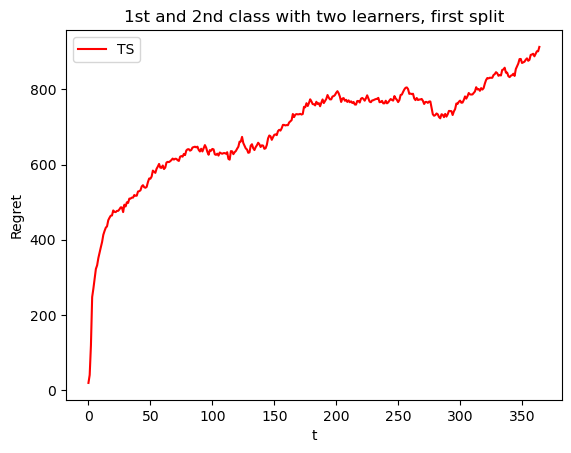

In [295]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.title("1st and 2nd class with two learners, first split")
plt.plot(np.cumsum(opt12-ts_reward_first_split, axis=0), 'r')
plt.legend(["TS"])
plt.show()

TS considering the second split, 3 classes (3 learners, one class at time)

In [296]:
#TS class 0 + 1 + 2 for tot days (3 classes, one at time)

E = E_commerce(binary_features=30)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 30*3
n_days = 365
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ts3_rewards_per_experiment = []


ts3_pulls_per_arm_per_experiment = []



for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = TS_poisson(n_arms=n_arms)

    for d in range(n_days):
        
        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)

    ts3_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts3_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)




E = E_commerce(binary_features=20)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 40*3
n_days = 365
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ts2_rewards_per_experiment = []


ts2_pulls_per_arm_per_experiment = []



for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = TS_poisson(n_arms=n_arms)

    for d in range(n_days):
        
        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)

    ts2_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts2_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)



E = E_commerce(binary_features=10)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 30*3
n_days = 365
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ts1_rewards_per_experiment = []


ts1_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = TS_poisson(n_arms=n_arms)

    for d in range(n_days):
        
        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)

    ts1_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts1_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)


In [297]:
print("TS",np.mean(np.mean(ts1_rewards_per_experiment, axis=0)), np.std(np.mean(ts1_rewards_per_experiment, axis=0)))
print("TS",np.mean(np.mean(ts2_rewards_per_experiment, axis=0)), np.std(np.mean(ts2_rewards_per_experiment, axis=0)))
print("TS",np.mean(np.mean(ts3_rewards_per_experiment, axis=0)), np.std(np.mean(ts3_rewards_per_experiment, axis=0)))

ts_all_classes_rewards = 0.3*(np.mean(ts1_rewards_per_experiment, axis=0))+0.4*(np.mean(ts2_rewards_per_experiment, axis=0))+0.3*np.mean(ts3_rewards_per_experiment, axis=0)


TS 141.43407433789957 14.13719457919283
TS 120.46212729223743 12.205016210565221
TS 107.24539356621005 11.351312159602294


In [298]:
opt123 = 0.3*opt1+0.4*opt2+0.3*opt3
opt123

125.66813416453681

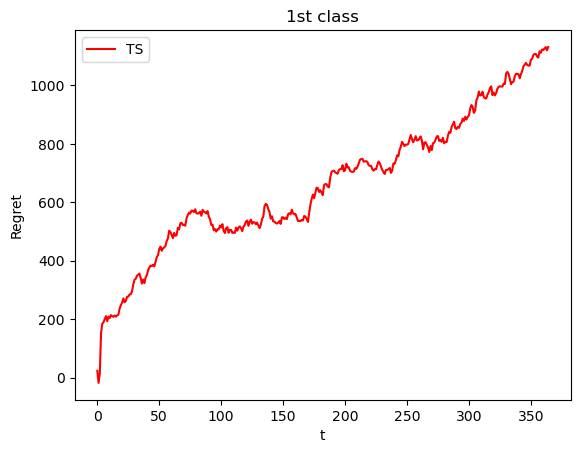

In [299]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.title("1st class")
plt.plot(np.cumsum(opt1-np.mean(ts1_rewards_per_experiment,axis=0), axis=0), 'r')
plt.legend(["TS"])
plt.show()

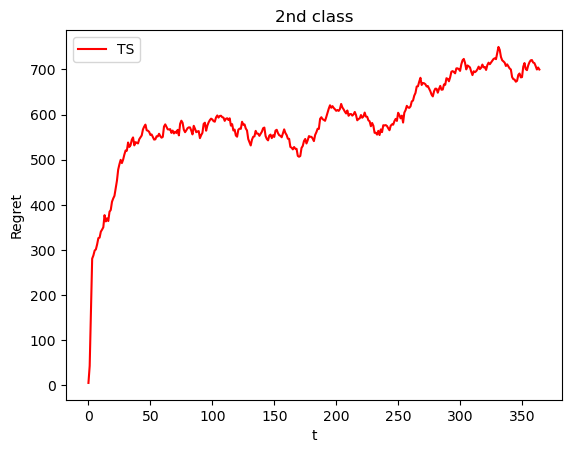

In [300]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.title("2nd class")
plt.plot(np.cumsum(opt2-np.mean(ts2_rewards_per_experiment,axis=0), axis=0), 'r')
plt.legend(["TS"])
plt.show()

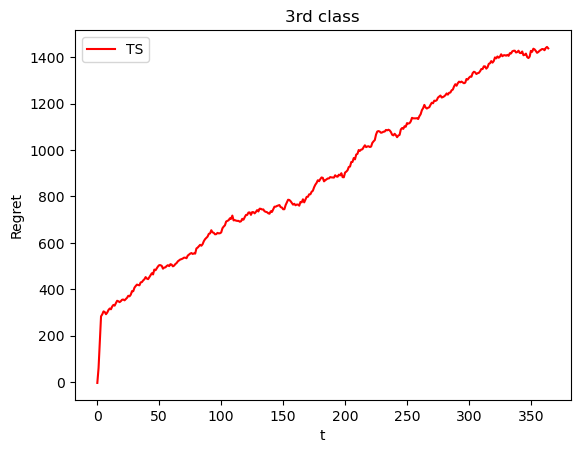

In [301]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.title("3rd class")
plt.plot(np.cumsum(opt3-np.mean(ts3_rewards_per_experiment,axis=0), axis=0), 'r')
plt.legend(["TS"])
plt.show()

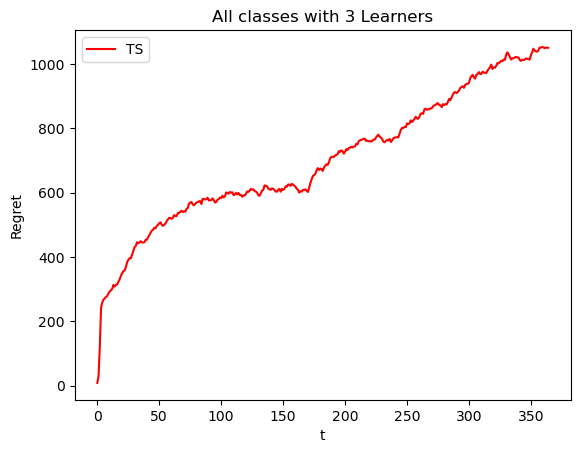

In [302]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.title("All classes with 3 Learners")
plt.plot(np.cumsum(opt123-ts_all_classes_rewards, axis=0), 'r')
plt.legend(["TS"])
plt.show()

In [303]:
print("_______________________________________________")
print("Considering all the experiments:")
print("-----------------------------------------------")
print("Total expected reward over",n_days, "days")
print(np.mean(np.sum(ts_all_classes_rewards)))
print("-----------------------------------------------")
print("Total expected regret over",n_days, "days")
print(np.mean(np.sum(opt123 - ts_all_classes_rewards)))

print("-----------------------------------------------")
print("Average expected reward per round over",n_days, "days")
print(np.mean(np.mean(ts_all_classes_rewards, axis=0)))
print("-----------------------------------------------")
print("Average expected regret per round over",n_days, "days")
print(np.mean(np.mean(opt123-ts_all_classes_rewards, axis=0)))


_______________________________________________
Considering all the experiments:
-----------------------------------------------
Total expected reward over 365 days
44817.87232016667
-----------------------------------------------
Total expected regret over 365 days
1050.9966498892672
-----------------------------------------------
Average expected reward per round over 365 days
122.78869128812786
-----------------------------------------------
Average expected regret per round over 365 days
2.8794428764089512


TS second split, 3 classes (1 leaner, all class at the same time)

In [312]:
#3 classes together (simultaneously)

E = E_commerce(binary_features=1)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 100
n_days = 365
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ts_rewards_per_experiment = []


ts_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = TS_poisson(n_arms=n_arms)

    for d in range(n_days):
        
        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)

In [313]:
#we don't use opt123 but opt_3_Classes because now they are all the 3 classes at the same time (we use the opt estimated by the Conv Rates learner which considered all the classes at the same time)
opt_3_classes

118.17314762734482

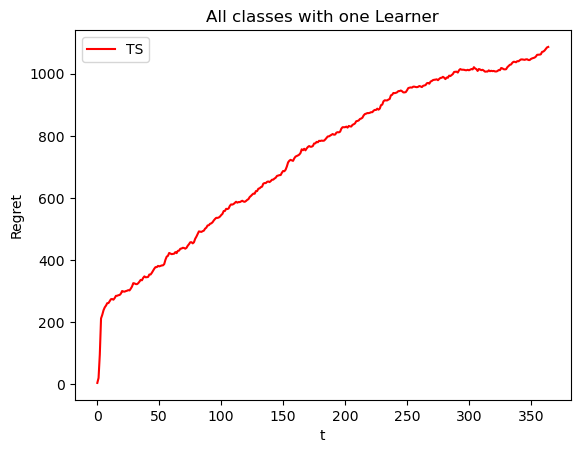

In [314]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.title("All classes with one Learner")
plt.plot(np.cumsum(opt_3_classes-np.mean(ts_rewards_per_experiment,axis=0), axis=0), 'r')
plt.legend(["TS"])
plt.show()

In [307]:
#We have better performance when we consider the three classes one at time (because we use three learners instead of one)

UCB

UCB with split2 (3 classes one at time, 3 learners)

In [308]:
#UCB class 0 + 1 + 2 for tot days

E = E_commerce(binary_features=30)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 30*3
n_days = 300
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ucb3_rewards_per_experiment = []


ucb3_pulls_per_arm_per_experiment = []



for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = UCB(n_arms=n_arms)

    for d in range(n_days):
        
        pulled_arm = ts_learner.pull_arm()
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward)

    ucb3_rewards_per_experiment.append(ts_learner.collected_rewards)

    ucb3_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)




E = E_commerce(binary_features=20)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 40*3
n_days = 300
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ucb2_rewards_per_experiment = []


ucb2_pulls_per_arm_per_experiment = []



for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = UCB(n_arms=n_arms)

    for d in range(n_days):
        
        pulled_arm = ts_learner.pull_arm()
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward)

    ucb2_rewards_per_experiment.append(ts_learner.collected_rewards)

    ucb2_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)



E = E_commerce(binary_features=10)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 30*3
n_days = 300
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ucb1_rewards_per_experiment = []


ucb1_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = UCB(n_arms=n_arms)

    for d in range(n_days):
        
        pulled_arm = ts_learner.pull_arm()
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward)

    ucb1_rewards_per_experiment.append(ts_learner.collected_rewards)

    ucb1_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)


In [309]:
print("TS",np.mean(np.mean(ts1_rewards_per_experiment, axis=0)), np.std(np.mean(ts1_rewards_per_experiment, axis=0)))
print("TS",np.mean(np.mean(ts2_rewards_per_experiment, axis=0)), np.std(np.mean(ts2_rewards_per_experiment, axis=0)))
print("TS",np.mean(np.mean(ts3_rewards_per_experiment, axis=0)), np.std(np.mean(ts3_rewards_per_experiment, axis=0)))

ucb_all_classes_rewards = 0.3*(np.mean(ucb1_rewards_per_experiment, axis=0))+0.4*(np.mean(ucb2_rewards_per_experiment, axis=0))+0.3*np.mean(ucb3_rewards_per_experiment, axis=0)


TS 141.43407433789957 14.13719457919283
TS 120.46212729223743 12.205016210565221
TS 107.24539356621005 11.351312159602294


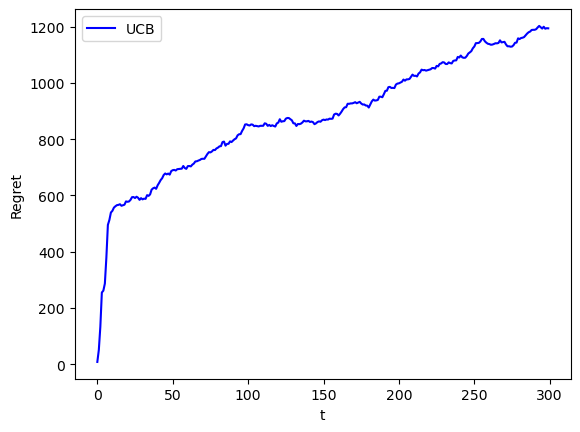

In [310]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(opt123-ucb_all_classes_rewards, axis=0), 'b')
plt.legend(["UCB"])
plt.show()

In [311]:
print("_______________________________________________")
print("Considering all the experiments:")
print("-----------------------------------------------")
print("Total expected reward over",n_days, "days")
print(np.mean(np.sum(ucb_all_classes_rewards)))
print("-----------------------------------------------")
print("Total expected regret over",n_days, "days")
print(np.mean(np.sum(opt123 - ucb_all_classes_rewards)))

print("-----------------------------------------------")
print("Average expected reward per round over",n_days, "days")
print(np.mean(np.mean(ucb_all_classes_rewards, axis=0)))
print("-----------------------------------------------")
print("Average expected regret per round over",n_days, "days")
print(np.mean(np.mean(opt123-ucb_all_classes_rewards, axis=0)))


_______________________________________________
Considering all the experiments:
-----------------------------------------------
Total expected reward over 300 days
36506.887817166666
-----------------------------------------------
Total expected regret over 300 days
1193.552432194375
-----------------------------------------------
Average expected reward per round over 300 days
121.68962605722221
-----------------------------------------------
Average expected regret per round over 300 days
3.978508107314583
